# Results Analysis

## Plot Bar Graph

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_graph(bars, labels, title, xticks):
    """
    Plots side-by-side bar charts.

    Args:
        bars (list): List of bar values for each group of bars.
        labels (list): List of labels for each set of bars.
        title (str): Title of the plot.
        xticks (list): List of labels for the x-axis ticks.
    """
    # Number of bars and labels
    num_bars = len(bars)
    num_labels = len(labels)

    # Ensure the number of bars and labels is the same
    if num_bars != num_labels:
        raise ValueError("The number of bars must be equal to the number of labels.")

    # Generate positions for the bars
    r = np.arange(len(bars[0]))

    # Set bar width
    bar_width = 1 / (num_bars + 1)

    # Colors for the bars
    colors = ['red', 'green', 'blue', 'orange', 'yellow']

    # Plot the bars
    for i in range(num_labels):
        plt.bar(r + i * bar_width, bars[i], color=colors[i], width=bar_width,
                edgecolor='white', label=labels[i])

    # Add labels, title, and legend to the plot
    plt.xlabel('CRUD Operations')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks(r + (num_bars - 1) * bar_width / 2, xticks)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()

## Setup DataFrame

In [2]:
import pandas as pd
from tabulate import tabulate
import re

with open('./go-projects/benchmark_results.log') as file:
    content = file.read()

# Define regex patterns to extract relevant information
methodology_pattern = r"==== Benchmark Results for tests/(?P<methodology>[\w/]+) ===="
benchmark_pattern = r"Benchmark(?P<operation>\w+)-\d+\s+\d+\s+(?P<time_per_op>\d+)\s+ns/op\s+(?P<bytes_per_op>\d+)\s+B/op\s+(?P<allocs_per_op>\d+)\s+allocs/op"

# Initialize lists to store the extracted data
records = []

# Split data by methodologies
sections = re.split(methodology_pattern, content)

# Process each section after the initial empty string in sections[0]
for i in range(1, len(sections), 2):
    methodology = sections[i]  # e.g., "DAONotation"
    benchmarks = sections[i + 1]  # content of the benchmarks
    matches = re.finditer(benchmark_pattern, benchmarks)
    for match in matches:
        operation = match.group("operation")
        time_per_op = int(match.group("time_per_op"))
        bytes_per_op = int(match.group("bytes_per_op"))
        allocs_per_op = int(match.group("allocs_per_op"))
        # Append record as a dictionary
        records.append({
            "methodology": methodology,
            "operation": operation,
            "time_per_op": time_per_op,
            "bytes_per_op": bytes_per_op,
            "allocs_per_op": allocs_per_op,
        })

# Convert records to a DataFrame
df = pd.DataFrame(records)

print(tabulate(df, headers='keys', tablefmt='pretty'))


+----+---------------+-----------------+-------------+--------------+---------------+
|    |  methodology  |    operation    | time_per_op | bytes_per_op | allocs_per_op |
+----+---------------+-----------------+-------------+--------------+---------------+
| 0  |  DAONotation  | InsertResources | 1073625900  |   1314576    |     34856     |
| 1  |  DAONotation  |  InsertProject  | 6719817800  |   3262400    |     74390     |
| 2  |  DAONotation  |   ReadProject   |  794974900  |   6483280    |    108420     |
| 3  |  DAONotation  |  UpdateProject  |  983180150  |   1008856    |     26266     |
| 4  |  DAONotation  |  DeleteProject  |  12100342   |     4169     |      93       |
| 5  | DirectStruct  | InsertResources | 1076202100  |    698448    |     17853     |
| 6  | DirectStruct  |  InsertProject  | 6577243000  |   2336944    |     58053     |
| 7  | DirectStruct  |   ReadProject   |  85338967   |   5357045    |    154188     |
| 8  | DirectStruct  |  UpdateProject  | 1025960100  |

In [3]:
def extract_data(df, class_name, attribute_benchmark):
    e1 = df[(df['methodology'] == class_name) & (df['operation'] == 'InsertResources')][attribute_benchmark].values
    e2 = df[(df['methodology'] == class_name) & (df['operation'] == 'InsertProject')][attribute_benchmark].values
    e3 = df[(df['methodology'] == class_name) & (df['operation'] == 'ReadProject')][attribute_benchmark].values
    e4 = df[(df['methodology'] == class_name) & (df['operation'] == 'UpdateProject')][attribute_benchmark].values
    e5 = df[(df['methodology'] == class_name) & (df['operation'] == 'DeleteProject')][attribute_benchmark].values
    test = [np.mean(e1) if e1.size > 0 else np.nan,
            np.mean(e2) if e2.size > 0 else np.nan,
            np.mean(e3) if e3.size > 0 else np.nan,
            np.mean(e4) if e4.size > 0 else np.nan,
            np.mean(e5) if e5.size > 0 else np.nan]
    return test

## Graphs

In [4]:
def plot_per(attribute_benchmark):
    # Extract benchmark data for each methodology and CRUD operation
    e1_dao, e2_dao, e3_dao, e4_dao, e5_dao = extract_data(df, 'DAONotation', attribute_benchmark)
    e1_dir, e2_dir, e3_dir, e4_dir, e5_dir = extract_data(df, 'DirectStruct', attribute_benchmark)
    e1_gor, e2_gor, e3_gor, e4_gor, e5_gor = extract_data(df, 'GORM', attribute_benchmark)
    e1_sql, e2_sql, e3_sql, e4_sql, e5_sql = extract_data(df, 'SQLRepository', attribute_benchmark)

    # Organize extracted data into lists for bar chart
    bars = [
        [e1_dao, e2_dao, e3_dao, e4_dao, e5_dao],
        [e1_dir, e2_dir, e3_dir, e4_dir, e5_dir],
        [e1_gor, e2_gor, e3_gor, e4_gor, e5_gor],
        [e1_sql, e2_sql, e3_sql, e4_sql, e5_sql]
    ]

    # Define labels, title, and x-ticks for the plot
    labels = ['DAONotation', 'DirectStruct', 'GORM', 'SQLRepository']
    title = 'Benchmark CRUD ' + attribute_benchmark
    xticks = ['Insert1', 'Insert2', 'Read', 'Update', 'Delete']

    # Plot the bar graph with the specified parameters
    plot_bar_graph(bars, labels, title, xticks)

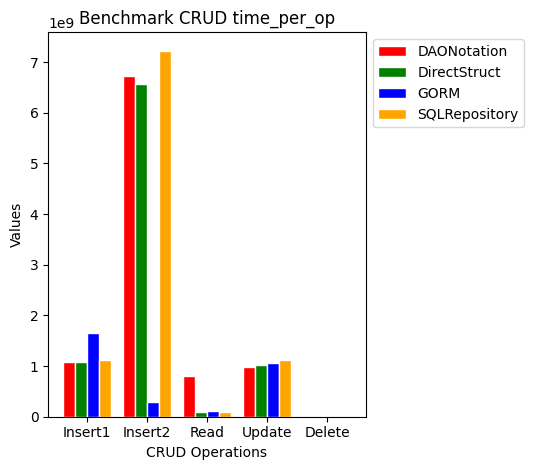

In [5]:
plot_per('time_per_op')

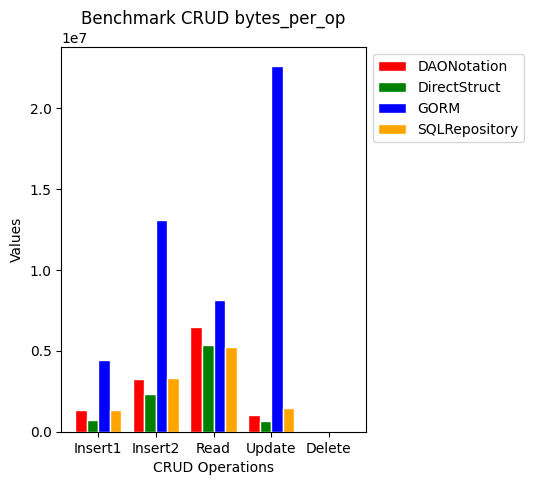

In [6]:
plot_per('bytes_per_op')

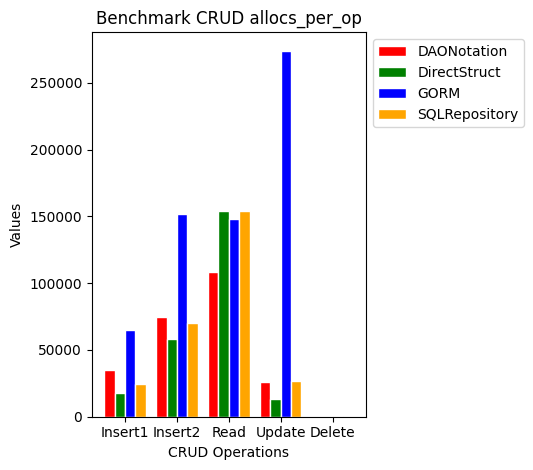

In [7]:
plot_per('allocs_per_op')

## Normalized Data

+----+---------------+-----------------+---------------------+----------------------+---------------------+
|    |  methodology  |    operation    |     time_per_op     |     bytes_per_op     |    allocs_per_op    |
+----+---------------+-----------------+---------------------+----------------------+---------------------+
| 0  |  DAONotation  | InsertResources | 0.6499792830155598  | 0.29592531362442864  | 0.5391659448088107  |
| 1  |  DAONotation  |  InsertProject  | 0.9296624983223771  | 0.24919636007101914  | 0.4901463388921467  |
| 2  |  DAONotation  |   ReadProject   |         1.0         |  0.794265170446624   | 0.7031675616779516  |
| 3  |  DAONotation  |  UpdateProject  | 0.8718588571058153  | 0.04459211792316225  | 0.09579803122754676 |
| 4  |  DAONotation  |  DeleteProject  | 0.7192699699365539  | 0.07015211684727737  | 0.13247863247863248 |
| 5  | DirectStruct  | InsertResources | 0.6515389292842506  | 0.15722821917512184  | 0.2761570350204183  |
| 6  | DirectStruct  |  Inse

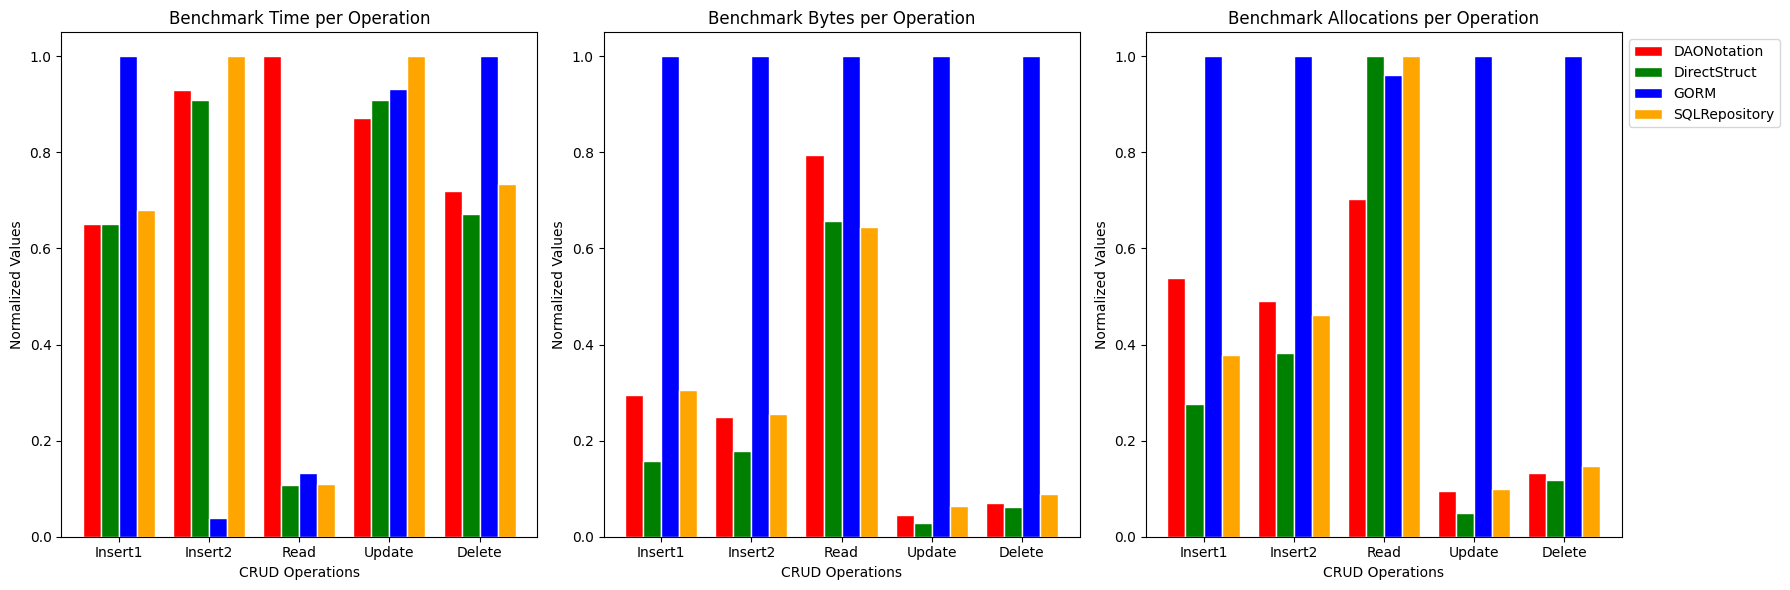

In [8]:
import matplotlib.pyplot as plt

def plot_all_metrics(df):
    # Define the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 3 subplots in a row

    # Plot for time_per_op
    attribute_benchmark = 'time_per_op'
    e1_dao, e2_dao, e3_dao, e4_dao, e5_dao = extract_data(df, 'DAONotation', attribute_benchmark)
    e1_dir, e2_dir, e3_dir, e4_dir, e5_dir = extract_data(df, 'DirectStruct', attribute_benchmark)
    e1_gor, e2_gor, e3_gor, e4_gor, e5_gor = extract_data(df, 'GORM', attribute_benchmark)
    e1_sql, e2_sql, e3_sql, e4_sql, e5_sql = extract_data(df, 'SQLRepository', attribute_benchmark)
    bars = [
        [e1_dao, e2_dao, e3_dao, e4_dao, e5_dao],
        [e1_dir, e2_dir, e3_dir, e4_dir, e5_dir],
        [e1_gor, e2_gor, e3_gor, e4_gor, e5_gor],
        [e1_sql, e2_sql, e3_sql, e4_sql, e5_sql]
    ]
    labels = ['DAONotation', 'DirectStruct', 'GORM', 'SQLRepository']
    xticks = ['Insert1', 'Insert2', 'Read', 'Update', 'Delete']
    plot_bar_graph(bars, labels, 'Benchmark Time per Operation', xticks, ax=axes[0])

    # Plot for bytes_per_op
    attribute_benchmark = 'bytes_per_op'
    e1_dao, e2_dao, e3_dao, e4_dao, e5_dao = extract_data(df, 'DAONotation', attribute_benchmark)
    e1_dir, e2_dir, e3_dir, e4_dir, e5_dir = extract_data(df, 'DirectStruct', attribute_benchmark)
    e1_gor, e2_gor, e3_gor, e4_gor, e5_gor = extract_data(df, 'GORM', attribute_benchmark)
    e1_sql, e2_sql, e3_sql, e4_sql, e5_sql = extract_data(df, 'SQLRepository', attribute_benchmark)
    bars = [
        [e1_dao, e2_dao, e3_dao, e4_dao, e5_dao],
        [e1_dir, e2_dir, e3_dir, e4_dir, e5_dir],
        [e1_gor, e2_gor, e3_gor, e4_gor, e5_gor],
        [e1_sql, e2_sql, e3_sql, e4_sql, e5_sql]
    ]
    plot_bar_graph(bars, labels, 'Benchmark Bytes per Operation', xticks, ax=axes[1])

    # Plot for allocs_per_op
    attribute_benchmark = 'allocs_per_op'
    e1_dao, e2_dao, e3_dao, e4_dao, e5_dao = extract_data(df, 'DAONotation', attribute_benchmark)
    e1_dir, e2_dir, e3_dir, e4_dir, e5_dir = extract_data(df, 'DirectStruct', attribute_benchmark)
    e1_gor, e2_gor, e3_gor, e4_gor, e5_gor = extract_data(df, 'GORM', attribute_benchmark)
    e1_sql, e2_sql, e3_sql, e4_sql, e5_sql = extract_data(df, 'SQLRepository', attribute_benchmark)
    bars = [
        [e1_dao, e2_dao, e3_dao, e4_dao, e5_dao],
        [e1_dir, e2_dir, e3_dir, e4_dir, e5_dir],
        [e1_gor, e2_gor, e3_gor, e4_gor, e5_gor],
        [e1_sql, e2_sql, e3_sql, e4_sql, e5_sql]
    ]
    plot_bar_graph(bars, labels, 'Benchmark Allocations per Operation', xticks, ax=axes[2], legend=True)

    plt.tight_layout()
    plt.show()

# Updated plot_bar_graph function to accept an axis parameter
def plot_bar_graph(bars, labels, title, xticks, ax=None, legend=False):
    """
    Plot side-by-side bar charts.

    Args:
        bars (list): List of vectors with bar values.
        labels (list): List of labels for the bars.
        title (str): Title of the chart.
        xticks (list): Labels for x-axis ticks.
        ax (matplotlib.axes.Axes): Optional, specify axis to plot on.
    """
    num_bars = len(bars)
    num_labels = len(labels)

    if num_bars != num_labels:
        raise ValueError("The number of bars must match the number of labels.")

    r = np.arange(len(bars[0]))
    bar_width = 1 / (num_bars + 1)
    colors = ['red', 'green', 'blue', 'orange', 'yellow']

    for i in range(num_labels):
        ax.bar(r + i * bar_width, bars[i], color=colors[i], width=bar_width,
               edgecolor='white', label=labels[i])

    ax.set_xlabel('CRUD Operations')
    ax.set_ylabel('Normalized Values')
    ax.set_title(title)
    ax.set_xticks(r + (num_bars - 1) * bar_width / 2)
    ax.set_xticklabels(xticks)
    if legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

df[['time_per_op', 'bytes_per_op', 'allocs_per_op']] = df.groupby('operation')[['time_per_op', 'bytes_per_op', 'allocs_per_op']].transform(lambda x: x / x.max())

print(tabulate(df, headers='keys', tablefmt='pretty'))

plot_all_metrics(df)